# Introduction to Euclid Q1 1D spectra

## Learning Goals

By the end of this tutorial, you will:
- Understand the basic characteristics of Euclid Q1 SIR 1D spectra.
- What columns are available in the MER catalog.
- How to query with ADQL in the MER catalog.
- How to make a simple color-magnitude diagram with the data.

## Introduction

++

Euclid is a European Space Agency (ESA) space mission with NASA participation, to study the geometry and nature of the dark Universe.
The Quick Data Release 1 (Q1) are the first data release from the Euclid mission after the Early Release Observations (ERO).
On March 19, 2025 the data will be available on the [ESA archive](https://easidr.esac.esa.int/sas/) and on the [IRSA archive](https://irsa.ipac.caltech.edu).

These Q1 notebooks focus on how to access, download, and process Euclid Q1 data from the IRSA archive.
If you have any issues accessing data from the archives, please contact the helpdesk directly: [IRSA helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) and [ESA Euclid Helpdesk](https://support.cosmos.esa.int/euclid).

For the Euclid Wide Survey standard operating mode, the telescope undertakes a 4-point dither pattern.
At each position VIS and NISP each take a 570s exposure, consisting of a direct visible image and a red grism exposure.
This is followed by further NISP exposures in the Y, J, and H band filters (112 seconds each).
The telescope is then dithered, and the sequence is repeated starting with a different grism position angle.
There are actually two operational grisms oriented 180 degrees from each other. Each grism which will be used twice in this sequence, but with slight angular offsets (+/- 4 degrees), effectively creating the four different grism angles (Scaramella et al. 2022, A&A 662, A112).

Data which can be obtained for SIR include: SIR "images", which effectively show the full image of objects with the spectral traces overlapping, and SIR 1D spectra for individual objects.
In this notebook we describe how to access and process the 1D spectra products.
For most users, simply accessing th 1D spectra is probably the preferred option, unless they would like to extract the spectrum again, or inspect the images to see if there is any artifact which might add noise to the spectrum.

This notebook provides an introduction to the SIR 1D spectra released as part of Euclid Q1.
Other Euclid notebooks show how to use other data products released as part of Euclid Q1.

## Imports

In [1]:
# Uncomment the next line to install dependencies if needed
# !pip install matplotlib pandas requests astropy pyvo

In [2]:
from io import BytesIO

import matplotlib.pyplot as plt
import pandas as pd
import requests

from astropy.io import fits
from astropy.table import Table

import pyvo as vo

## 1. Download 1D spectra from IRSA directly to this notebook

Search for all tables in IRSA labeled as euclid

In [3]:
service = vo.dal.TAPService("https://irsa.ipac.caltech.edu/TAP")

tables = service.tables
for tablename in tables.keys():
    if "tap_schema" not in tablename and "euclid" in tablename:
            tables[tablename].describe()

euclid.artifact_euclid_q1
    Euclid Q1 CAOM Artifact Table

euclid.objectid_spectrafile_association_q1
    Euclid Q1 Object ID to Spectral File Association Table

euclid.observation_euclid_q1
    Euclid Q1 CAOM Observation Table
euclid.plane_euclid_q1
    Euclid Q1 CAOM Plane Table

euclid.tileid_association_q1
    Euclid Q1 TILEID to Observation ID Association Table
euclid_q1_mer_catalogue
    Euclid Q1 MER Catalog

euclid_q1_mer_morphology
    Euclid Q1 MER Morphology

euclid_q1_phz_photo_z
    Euclid Q1 PHZ Photo-z Catalog
euclid_q1_spe_lines_atomic_indices
    Euclid Q1 SPE Lines Catalog - Atomic Indices

euclid_q1_spe_lines_continuum_features
    Euclid Q1 SPE Lines Catalog - Continuum Features

euclid_q1_spe_lines_line_features
    Euclid Q1 SPE Lines Catalog - Spectral Lines
euclid_q1_spe_lines_molecular_indices
    Euclid Q1 SPE Lines Catalog - Molecular Indices

euclid_q1_spectro_zcatalog_spe_classification
    Euclid Q1 SPE Redshift Catalog - Classification

euclid_q1_spectr

euclid.plane_euclid_q1
    Euclid Q1 CAOM Plane Table

euclid.tileid_association_q1
    Euclid Q1 TILEID to Observation ID Association Table



euclid_q1_mer_catalogue
    Euclid Q1 MER Catalog

euclid_q1_mer_morphology
    Euclid Q1 MER Morphology

euclid_q1_phz_photo_z
    Euclid Q1 PHZ Photo-z Catalog



euclid_q1_spe_lines_atomic_indices
    Euclid Q1 SPE Lines Catalog - Atomic Indices

euclid_q1_spe_lines_continuum_features
    Euclid Q1 SPE Lines Catalog - Continuum Features

euclid_q1_spe_lines_line_features
    Euclid Q1 SPE Lines Catalog - Spectral Lines



euclid_q1_spe_lines_molecular_indices
    Euclid Q1 SPE Lines Catalog - Molecular Indices

euclid_q1_spectro_zcatalog_spe_classification
    Euclid Q1 SPE Redshift Catalog - Classification

euclid_q1_spectro_zcatalog_spe_galaxy_candidates
    Euclid Q1 SPE Redshift Catalog - Galaxy Candidates



euclid_q1_spectro_zcatalog_spe_qso_candidates
    Euclid Q1 SPE Redshift Catalog - QSO Candidates

euclid_q1_spectro_zcatalog_spe_quality
    Euclid Q1 SPE Redshift Catalog - Quality

euclid_q1_spectro_zcatalog_spe_star_candidates
    Euclid Q1 SPE Redshift Catalog - Star Candidates



In [4]:
table_mer= 'euclid_q1_mer_catalogue'
table_1dspectra= 'euclid.objectid_spectrafile_association_q1'
table_phz= 'euclid_q1_phz_photo_z'
table_galaxy_candidates= 'euclid_q1_spectro_zcatalog_spe_galaxy_candidates'

In [5]:
## Change the settings so we can see all the columns in the dataframe and the full column width
## (to see the full long URL)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


## Can use the following lines to reset the max columns and column width of pandas
# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_colwidth')

## 2. Search for the spectrum of a specific galaxy in the 1D spectra table

In [6]:
obj_id=2739401293646823742

## Pull the data on these objects
adql_object = f"SELECT * \
FROM {table_1dspectra} \
WHERE objectid = {obj_id} \
AND uri IS NOT NULL "

## Pull the data on this particular galaxy
result2 = service.search(adql_object)
df2=result2.to_table().to_pandas()
df2

,objectid,tileid,uri,hdu,cntr
0,2739401293646823742,102158277,ibe/data/euclid/q1/SIR/102158277/EUC_SIR_W-COMBSPEC_102158277_2024-11-05T15:54:45.882858Z.fits,1633,138385


### Create the full filename/url

In [7]:
irsa_url='https://irsa.ipac.caltech.edu/'

file_url=irsa_url+df2['uri'].iloc[0]
file_url

'https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/SIR/102158277/EUC_SIR_W-COMBSPEC_102158277_2024-11-05T15:54:45.882858Z.fits'

## 3. Read in the spectrum using the file_url and the extension just for this object

Currently IRSA has the spectra stored in very large files containing multiple (14220) extensions with spectra of many targets within one tile. You can choose to read in the big file below to see what it looks like (takes a few mins to load) or skip this step and just read in the specific extension we want for the 1D spectra (recommended).

In [8]:
#### Code to read in the large file with many extensions and spectra from a tile
#### Currently commented out

# ## Complete file url with the irsa url at the start
# url = file_url
# response = requests.get(url)

# hdul = fits.open(BytesIO(response.content))  # Open FITS file from memory
# hdul.info()  # Show file info

### Open the large FITS file without loading it entirely into memory, pulling out just the extension we want for the 1D spectra of our object

In [9]:
response = requests.get(file_url)

with fits.open(BytesIO(response.content), memmap=True) as hdul:
    hdu = hdul[df2['hdu'].iloc[0]]
    dat = Table.read(hdu, format='fits', hdu=1)
    df_obj_irsa = dat.to_pandas()

### Plot the image of the extracted spectrum

- Convert the wavelength to microns

Text(0.5, 1.0, '2739401293646823742')

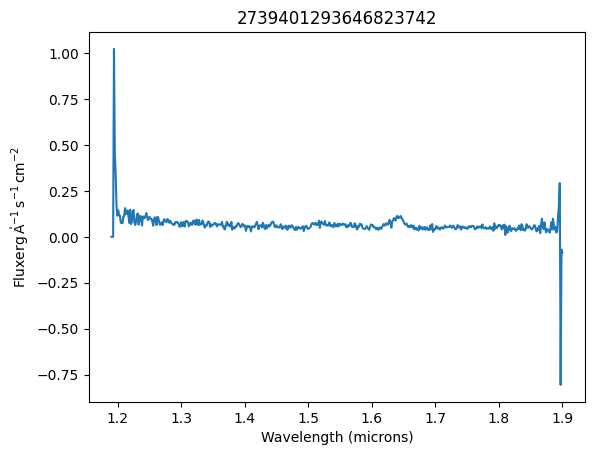

In [10]:
## Now the data are read in, show an image

## Converting from Angstrom to microns
plt.plot(df_obj_irsa['WAVELENGTH']/10000., df_obj_irsa['SIGNAL'])

plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux'+dat['SIGNAL'].unit.to_string('latex_inline'))
plt.title(obj_id)

## About this Notebook

**Author**: Tiffany Meshkat (IPAC Scientist)

**Updated**: 2025-03-19

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.